In [7]:
# prompt: mount drive

from google.colab import drive
drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


In [8]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional, Layer, Input
from tensorflow.keras import backend as K
import matplotlib.pyplot as plt

In [3]:
# prompt: nvda smi

!nvidia-smi


Mon Mar 24 06:20:14 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA A100-SXM4-40GB          Off |   00000000:00:04.0 Off |                    0 |
| N/A   29C    P0             41W /  400W |       0MiB /  40960MiB |      0%      Default |
|                                         |                        |             Disabled |
+-----------------------------------------+-----

Loading data from appl_data_with_indicators.csv...
Loading data from sentiment_analysis_detailed.csv...
Testing: seq_length=30, batch_size=32, lstm_units=64, dropout_rate=0.2
Epoch 1/100
101/101 ━━━━━━━━━━━━━━━━━━━━ 6s 17ms/step - loss: 0.0178 - val_loss: 2.0054e-04
Epoch 2/100
101/101 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0028 - val_loss: 0.0031
Epoch 3/100
101/101 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0027 - val_loss: 3.8968e-04
Epoch 4/100
101/101 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0022 - val_loss: 1.7451e-04
Epoch 5/100
101/101 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0013 - val_loss: 1.4957e-04
Epoch 6/100
101/101 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0045 - val_loss: 1.2651e-04
Epoch 7/100
101/101 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0024 - val_loss: 2.1164e-04
Epoch 8/100
101/101 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0011 - val_loss: 5.3010e-04
Epoch 9/100
101/101 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0015 - val_loss: 2.4380e-04
E

Final model saved to models/lstm_model.h5
Train RMSE: 17.62, Test RMSE: 5.48


<ipython-input-11-7cca33c172cc>:131: RuntimeWarning: divide by zero encountered in divide
  confidence = 1 - (errors / max_error)



Predicted price for next day: $263.92
Confidence level: -inf%
No trading signal - confidence below threshold
Predictions saved to lstm_predictions.csv


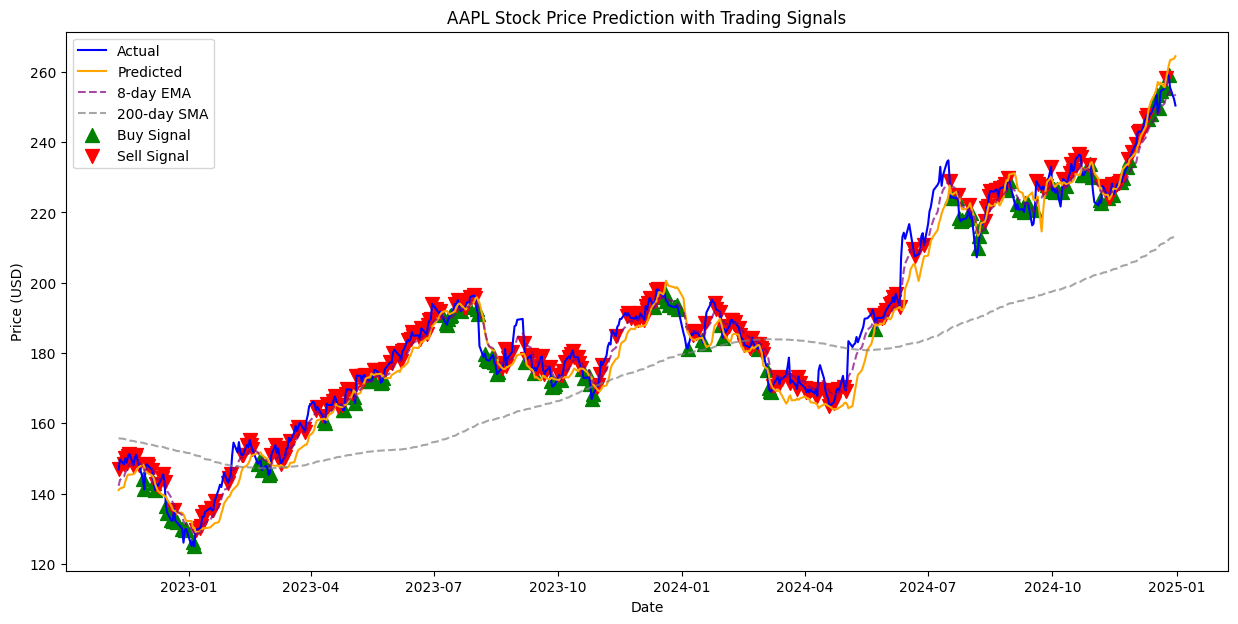

In [11]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional, Layer, Input
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import backend as K
import matplotlib.pyplot as plt

# Configuration
CONFIG = {
    'SYMBOL': 'AAPL',
    'SEQUENCE_LENGTHS': [30, 60, 90],
    'TRAIN_SIZE_RATIO': 0.85,
    'EPOCHS':100,
    'BATCH_SIZES': [32, 64],
    'LSTM_UNITS': [64, 128],
    'DROPOUT_RATES': [0.2, 0.3, 0.5],
    'MODEL_OPTIMIZER': 'adam',
    'MODEL_LOSS': 'mse',
    'CONFIDENCE_THRESHOLD': 0.95,
    'START_DATE': '2010-01-01',
    'END_DATE': '2025-01-01'
}

class AttentionLayer(Layer):
    def __init__(self, **kwargs):
        super(AttentionLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        self.W = self.add_weight(name='attention_weight',
                               shape=(input_shape[-1], 1),
                               initializer='random_normal',
                               trainable=True)
        self.b = self.add_weight(name='attention_bias',
                               shape=(input_shape[1], 1),
                               initializer='zeros',
                               trainable=True)
        super(AttentionLayer, self).build(input_shape)

    def call(self, x):
        # Alignment scores. Pass through tanh activation
        e = K.tanh(K.dot(x, self.W) + self.b)
        # Remove dimension of size 1
        e = K.squeeze(e, axis=-1)
        # Compute softmax
        alpha = K.softmax(e)
        # Reshape to match original input shape
        alpha = K.expand_dims(alpha, axis=-1)
        # Multiply input by attention weights
        context = x * alpha
        context = K.sum(context, axis=1)
        return context

    def compute_output_shape(self, input_shape):
        return (input_shape[0], input_shape[-1])

    def get_config(self):
        return super(AttentionLayer, self).get_config()

def load_and_prepare_data():
    """Load and prepare both price and sentiment data."""
    # Load price data with indicators
    print("Loading data from appl_data_with_indicators.csv...")
    df_price = pd.read_csv('/content/drive/MyDrive/LSTM/appl_data_with_indicators.csv')
    df_price['Date'] = pd.to_datetime(df_price['Unnamed: 0'])
    df_price.set_index('Date', inplace=True)
    df_price = df_price.sort_index()

    # Load sentiment data
    print("Loading data from sentiment_analysis_detailed.csv...")
    df_sentiment = pd.read_csv('/content/drive/MyDrive/LSTM/sentiment_analysis_detailed.csv')
    # Convert published_at to datetime and extract date more robustly
    df_sentiment['Date'] = pd.to_datetime(df_sentiment['published_at'], utc=True).dt.strftime('%Y-%m-%d')
    df_sentiment['Date'] = pd.to_datetime(df_sentiment['Date'])
    df_sentiment = df_sentiment.groupby('Date').agg({
        'sentiment_positive': 'mean',
        'sentiment_neutral': 'mean',
        'sentiment_negative': 'mean'
    }).reset_index()
    df_sentiment['Date'] = pd.to_datetime(df_sentiment['Date'])
    df_sentiment.set_index('Date', inplace=True)

    # Merge price and sentiment data
    df = df_price.join(df_sentiment, how='left')

    # Forward fill sentiment scores for days without news
    df[['sentiment_positive', 'sentiment_neutral', 'sentiment_negative']] = \
        df[['sentiment_positive', 'sentiment_neutral', 'sentiment_negative']].ffill()

    # If there are still NaN values at the start, backward fill
    df[['sentiment_positive', 'sentiment_neutral', 'sentiment_negative']] = \
        df[['sentiment_positive', 'sentiment_neutral', 'sentiment_negative']].bfill()

    # Fill any remaining NaN values with neutral sentiment
    df[['sentiment_positive', 'sentiment_neutral', 'sentiment_negative']] = \
        df[['sentiment_positive', 'sentiment_neutral', 'sentiment_negative']].fillna(1/3)

    # Filter date range
    df = df[(df.index >= CONFIG['START_DATE']) & (df.index <= CONFIG['END_DATE'])]

    return df

def create_sequences(data, seq_length):
    """Create sequences from multivariate data."""
    sequences, targets = [], []
    for i in range(len(data) - seq_length):
        sequences.append(data[i:i + seq_length])
        targets.append(data[i + seq_length, 0])  # Target is still the closing price
    return np.array(sequences), np.array(targets)

def build_lstm_model(seq_length, n_features, lstm_units, dropout_rate):
    """Build Bidirectional LSTM model with attention mechanism."""
    inputs = Input(shape=(seq_length, n_features))
    x = Bidirectional(LSTM(lstm_units, return_sequences=True))(inputs)
    x = Dropout(dropout_rate)(x)
    x = Bidirectional(LSTM(lstm_units // 2, return_sequences=True))(x)
    x = Dropout(dropout_rate)(x)
    x = AttentionLayer()(x)
    x = Dense(32, activation='relu')(x)
    outputs = Dense(1)(x)

    model = Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer=CONFIG['MODEL_OPTIMIZER'], loss=CONFIG['MODEL_LOSS'])
    return model

def calculate_confidence(predictions, actuals):
    """Calculate confidence based on prediction error."""
    errors = np.abs(predictions - actuals.flatten())
    max_error = np.max(actuals) - np.min(actuals)
    confidence = 1 - (errors / max_error)
    return confidence

def generate_trading_signals(predictions, actuals, confidence_threshold):
    """Generate trading signals based on predictions and confidence."""
    confidence = calculate_confidence(predictions.flatten(), actuals)
    signals = np.zeros(len(predictions))

    # Generate signals where confidence is high enough
    high_confidence = confidence >= confidence_threshold
    price_diff = predictions.flatten() - actuals.flatten()

    signals[high_confidence & (price_diff > 0)] = 1  # Buy signals
    signals[high_confidence & (price_diff < 0)] = -1  # Sell signals

    return signals, confidence

def find_best_hyperparameters(data, train_size):
    """Find the best hyperparameters for the LSTM model."""
    best_val_loss = float('inf')
    best_model = None
    best_history = None
    best_params = None

    # Define early stopping callback
    early_stopping = EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True,
        verbose=1
    )

    for seq_length in CONFIG['SEQUENCE_LENGTHS']:
        X, y = create_sequences(data, seq_length)
        X_train, X_val = X[:train_size], X[train_size:]
        y_train, y_val = y[:train_size], y[train_size:]

        for batch_size in CONFIG['BATCH_SIZES']:
            for lstm_units in CONFIG['LSTM_UNITS']:
                for dropout_rate in CONFIG['DROPOUT_RATES']:
                    print(f"Testing: seq_length={seq_length}, batch_size={batch_size}, "
                          f"lstm_units={lstm_units}, dropout_rate={dropout_rate}")

                    model = build_lstm_model(seq_length, X.shape[2], lstm_units, dropout_rate)
                    history = model.fit(
                        X_train, y_train,
                        epochs=CONFIG['EPOCHS'],
                        batch_size=batch_size,
                        validation_data=(X_val, y_val),
                        callbacks=[early_stopping],
                        verbose=1
                    )

                    val_loss = min(history.history['val_loss'])
                    if val_loss < best_val_loss:
                        best_val_loss = val_loss
                        best_model = model
                        best_history = history
                        best_params = {
                            'sequence_length': seq_length,
                            'batch_size': batch_size,
                            'lstm_units': lstm_units,
                            'dropout_rate': dropout_rate
                        }

                    print(f"Validation loss: {val_loss:.6f}")

    print("\nBest parameters:")
    for param, value in best_params.items():
        print(f"{param}: {value}")
    print(f"Best validation loss: {best_val_loss:.6f}")

    return best_model, best_history, best_params

def main():
    # Load and prepare data
    df = load_and_prepare_data()

    # Select features for the model
    feature_columns = [
        'Close', 'EMA_8', 'SMA_200',
        'RSI', 'MACD', 'Signal_Line', 'MACD_Histogram',
        'BB_upper', 'BB_middle', 'BB_lower',
        'Volume',
        'sentiment_positive', 'sentiment_neutral', 'sentiment_negative'
    ]

    # Verify which columns are actually available
    available_columns = [col for col in feature_columns if col in df.columns]
    missing_columns = set(feature_columns) - set(available_columns)
    if missing_columns:
        print(f"Warning: The following columns are missing and will be excluded: {missing_columns}")
        feature_columns = available_columns

    # Clean and convert
    for col in feature_columns:
        df[col] = pd.to_numeric(df[col], errors='coerce')
    df.dropna(inplace=True)

    # Scale the features
    scaler = MinMaxScaler()
    scaled_data = scaler.fit_transform(df[feature_columns])

    # Split into training and testing
    train_size = int(len(scaled_data) * CONFIG['TRAIN_SIZE_RATIO'])

    # Tune and get best model
    best_model, history, best_params = find_best_hyperparameters(scaled_data, train_size)

    # Final training and prediction
    X, y = create_sequences(scaled_data, best_params['sequence_length'])
    X_train, X_test = X[:train_size], X[train_size:]
    y_train, y_test = y[:train_size], y[train_size:]

    # Predictions
    best_model.fit(X_train, y_train, epochs=CONFIG['EPOCHS'],
                  batch_size=best_params['batch_size'], verbose=0)
    best_model.save('models/lstm_model.h5')
    print("Final model saved to models/lstm_model.h5")

    train_predictions = best_model.predict(X_train, verbose=0)
    test_predictions = best_model.predict(X_test, verbose=0)

    # Inverse transform predictions (for closing price only)
    close_price_scaler = MinMaxScaler()
    close_price_scaler.fit_transform(df[['Close']])

    train_predictions = close_price_scaler.inverse_transform(train_predictions)
    test_predictions = close_price_scaler.inverse_transform(test_predictions)
    y_train_inv = close_price_scaler.inverse_transform(y_train.reshape(-1, 1))
    y_test_inv = close_price_scaler.inverse_transform(y_test.reshape(-1, 1))

    # Confidence and Signals
    test_signals, confidence = generate_trading_signals(test_predictions, y_test_inv,
                                                      CONFIG['CONFIDENCE_THRESHOLD'])

    # RMSE
    train_rmse = np.sqrt(np.mean((train_predictions - y_train_inv) ** 2))
    test_rmse = np.sqrt(np.mean((test_predictions - y_test_inv) ** 2))
    print(f"Train RMSE: {train_rmse:.2f}, Test RMSE: {test_rmse:.2f}")

    # Plotting
    plt.figure(figsize=(15, 7))
    plt.plot(df.index[-len(y_test_inv):], y_test_inv, label='Actual', color='blue')
    plt.plot(df.index[-len(test_predictions):], test_predictions, label='Predicted', color='orange')

    # Add EMA and SMA lines
    plt.plot(df.index[-len(y_test_inv):], df['EMA_8'].iloc[-len(y_test_inv):],
            label='8-day EMA', color='purple', linestyle='--', alpha=0.7)
    plt.plot(df.index[-len(y_test_inv):], df['SMA_200'].iloc[-len(y_test_inv):],
            label='200-day SMA', color='gray', linestyle='--', alpha=0.7)

    buy_signals = test_signals == 1
    sell_signals = test_signals == -1
    plt.scatter(df.index[-len(y_test_inv):][buy_signals], y_test_inv[buy_signals],
               color='green', marker='^', s=100, label='Buy Signal')
    plt.scatter(df.index[-len(y_test_inv):][sell_signals], y_test_inv[sell_signals],
               color='red', marker='v', s=100, label='Sell Signal')

    plt.title('AAPL Stock Price Prediction with Trading Signals')
    plt.xlabel('Date')
    plt.ylabel('Price (USD)')
    plt.legend()
    plt.savefig('training_history.png')

    # Next day prediction
    last_sequence = scaled_data[-best_params['sequence_length']:]
    last_sequence = last_sequence.reshape((1, best_params['sequence_length'], scaled_data.shape[1]))
    next_day_pred = best_model.predict(last_sequence, verbose=0)
    next_day_pred = close_price_scaler.inverse_transform(next_day_pred)

    last_actual = df['Close'].iloc[-1]
    confidence_next = calculate_confidence(next_day_pred.flatten(), np.array([last_actual]))

    print(f"\nPredicted price for next day: ${next_day_pred[0][0]:.2f}")
    print(f"Confidence level: {confidence_next[0]:.2%}")

    if confidence_next[0] >= CONFIG['CONFIDENCE_THRESHOLD']:
        if next_day_pred[0][0] > last_actual:
            print("High confidence BUY signal")
        else:
            print("High confidence SELL signal")
    else:
        print("No trading signal - confidence below threshold")

    # Save predictions with additional features
    predictions_df = pd.DataFrame({
        'Date': df.index[-len(test_predictions):],
        'Actual': y_test_inv.flatten(),
        'Predicted': test_predictions.flatten(),
        'Signal': test_signals.flatten(),
        'Confidence': confidence.flatten(),
        'EMA_8': df['EMA_8'].iloc[-len(test_predictions):].values,
        'SMA_200': df['SMA_200'].iloc[-len(test_predictions):].values,
        'Sentiment_Positive': df['sentiment_positive'].iloc[-len(test_predictions):].values,
        'Sentiment_Neutral': df['sentiment_neutral'].iloc[-len(test_predictions):].values,
        'Sentiment_Negative': df['sentiment_negative'].iloc[-len(test_predictions):].values
    })
    predictions_df.to_csv('lstm_predictions.csv', index=False)
    print("Predictions saved to lstm_predictions.csv")

if __name__ == "__main__":
    main()


In [16]:
import pandas as pd
import numpy as np

# Trading simulation configuration
INITIAL_BANKROLL = 10000
TRADE_PERCENTAGE = 0.3  # Default trade percentage if not using confidence-based sizing
CONFIDENCE_THRESHOLD = 0.95  # Minimum confidence level required to execute trades
STOP_LOSS_PERCENTAGE = 0.03  # % stop loss
PREDICTIONS_FILE = 'lstm_predictions.csv'

# Confidence-based trade sizing configuration
CONFIDENCE_TRADE_SIZES = {
    0.99: 0.4,  # 40% of bankroll for very high confidence trades
    0.97: 0.3,  # 30% of bankroll for high confidence trades
    0.95: 0.2,  # 20% of bankroll for moderate confidence trades
}

def simulate_trading(predictions_file=PREDICTIONS_FILE,
                    initial_bankroll=INITIAL_BANKROLL,
                    trade_percentage=TRADE_PERCENTAGE,
                    confidence_threshold=CONFIDENCE_THRESHOLD,
                    stop_loss_percentage=STOP_LOSS_PERCENTAGE):
    # Load predictions
    df = pd.read_csv(predictions_file)

    # Initialize variables
    bankroll = initial_bankroll
    position = 0  # 0 = no position, 1 = long position
    shares = 0
    trades = []
    entry_price = 0  # Track entry price for calculating profit/loss
    profitable_trades = 0
    total_trades = 0
    stop_loss_triggered = 0  # Track number of stop loss triggers

    # Iterate through predictions
    for i in range(len(df)):
        current_price = df['Actual'].iloc[i]
        signal = df['Signal'].iloc[i]
        date = df['Date'].iloc[i]
        confidence = df['Confidence'].iloc[i] if 'Confidence' in df.columns else 1.0

        # Determine trade percentage based on confidence using configuration
        current_trade_percentage = 0  # Default to no trade
        for conf_threshold, trade_size in sorted(CONFIDENCE_TRADE_SIZES.items(), reverse=True):
            if confidence >= conf_threshold:
                current_trade_percentage = trade_size
                break

        # Calculate trade amount based on confidence-adjusted percentage
        trade_amount = bankroll * current_trade_percentage

        # Check stop loss if we have a position
        if position == 1:
            loss_percentage = (current_price - entry_price) / entry_price
            if loss_percentage <= -stop_loss_percentage:
                # Stop loss triggered - sell position
                trade_value = shares * current_price
                bankroll += trade_value
                position = 0

                # Calculate loss
                profit = trade_value - (shares * entry_price)
                total_trades += 1
                stop_loss_triggered += 1

                trades.append({
                    'Date': date,
                    'Action': 'STOP_LOSS',
                    'Price': current_price,
                    'Shares': shares,
                    'Trade Amount': trade_value,
                    'Bankroll': bankroll,
                    'Profit': profit,
                    'Confidence': confidence,
                    'Loss Percentage': loss_percentage * 100
                })
                shares = 0
                continue

        # Process buy signal with confidence check
        if signal == 1 and position == 0 and confidence >= confidence_threshold:
            shares = trade_amount / current_price
            bankroll -= trade_amount
            position = 1
            entry_price = current_price
            trades.append({
                'Date': date,
                'Action': 'BUY',
                'Price': current_price,
                'Shares': shares,
                'Trade Amount': trade_amount,
                'Bankroll': bankroll,
                'Confidence': confidence
            })

        # Process sell signal
        elif signal == -1 and position == 1:
            trade_value = shares * current_price
            bankroll += trade_value
            position = 0

            # Calculate if trade was profitable
            profit = trade_value - (shares * entry_price)
            if profit > 0:
                profitable_trades += 1
            total_trades += 1

            trades.append({
                'Date': date,
                'Action': 'SELL',
                'Price': current_price,
                'Shares': shares,
                'Trade Amount': trade_value,
                'Bankroll': bankroll,
                'Profit': profit,
                'Confidence': confidence
            })
            shares = 0

    # Close any remaining position using the last price
    if position == 1:
        trade_value = shares * df['Actual'].iloc[-1]
        bankroll += trade_value

        # Calculate if final trade was profitable
        profit = trade_value - (shares * entry_price)
        if profit > 0:
            profitable_trades += 1
        total_trades += 1

        trades.append({
            'Date': df['Date'].iloc[-1],
            'Action': 'SELL',
            'Price': df['Actual'].iloc[-1],
            'Shares': shares,
            'Trade Amount': trade_value,
            'Bankroll': bankroll,
            'Profit': profit,
            'Confidence': df['Confidence'].iloc[-1] if 'Confidence' in df.columns else 1.0
        })

    # Calculate performance metrics
    total_profit_loss = bankroll - initial_bankroll
    roi_percentage = (total_profit_loss / initial_bankroll) * 100
    win_rate = (profitable_trades / total_trades * 100) if total_trades > 0 else 0

    # Create trades DataFrame
    trades_df = pd.DataFrame(trades)

    return {
        'final_bankroll': bankroll,
        'total_profit_loss': total_profit_loss,
        'roi_percentage': roi_percentage,
        'win_rate': win_rate,
        'total_trades': total_trades,
        'profitable_trades': profitable_trades,
        'stop_loss_triggered': stop_loss_triggered,
        'trades': trades_df
    }

def main():
    # Run simulation
    results = simulate_trading()

    # Print results
    print("\nTrading Simulation Results")
    print("=" * 50)
    print(f"Initial Bankroll: ${INITIAL_BANKROLL:,.2f}")
    print(f"Confidence Threshold: {CONFIDENCE_THRESHOLD:.2f}")
    print(f"Stop Loss Percentage: {STOP_LOSS_PERCENTAGE:.1%}")
    print(f"Final Bankroll: ${results['final_bankroll']:,.2f}")
    print(f"Total Profit/Loss: ${results['total_profit_loss']:,.2f}")
    print(f"ROI: {results['roi_percentage']:.2f}%")
    print(f"Win Rate: {results['win_rate']:.2f}%")
    print(f"Total Trades: {results['total_trades']}")
    print(f"Profitable Trades: {results['profitable_trades']}")
    print(f"Stop Loss Triggers: {results['stop_loss_triggered']}")

    # Print trade history
    print("\nTrade History:")
    print("=" * 50)
    if len(results['trades']) > 0:
        print(results['trades'].to_string(index=False))
    else:
        print("No trades were executed")

if __name__ == "__main__":
    main()


Trading Simulation Results
Initial Bankroll: $10,000.00
Confidence Threshold: 0.95
Stop Loss Percentage: 3.0%
Final Bankroll: $10,615.21
Total Profit/Loss: $615.21
ROI: 6.15%
Win Rate: 69.81%
Total Trades: 53
Profitable Trades: 37
Stop Loss Triggers: 12

Trade History:
      Date    Action  Price    Shares  Trade Amount     Bankroll  Confidence      Profit  Loss Percentage
2022-11-28       BUY 144.22 13.867702   2000.000000  8000.000000    0.969908         NaN              NaN
2022-11-30      SELL 148.03 13.867702   2052.835945 10052.835945    0.987036   52.835945              NaN
2022-12-06       BUY 142.91 21.103147   3015.850784  7036.985162    0.989299         NaN              NaN
2022-12-08      SELL 142.65 21.103147   3010.363965 10047.349127    0.992965   -5.486818              NaN
2022-12-15       BUY 136.50 22.082086   3014.204738  7033.144389    0.979929         NaN              NaN
2022-12-19 STOP_LOSS 132.37 22.082086   2923.005723  9956.150112    0.969196  -91.199015     